In [86]:
# import packages
%pylab inline

import xarray as xr
import pandas as pd

import os

#import statsmodels.api as sm
#import statsmodels.formula.api as smf

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.util import add_cyclic_point

import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colorbar, colors

import numpy as np
from scipy.stats import poisson
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
# detrending and putting back mask
from scipy.signal import detrend

import random
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import regionmask

from scipy.stats import linregress

import sys
wython = '/tigress/wenchang/wython'
if wython not in sys.path: sys.path.append(wython)
from xtc import wherebasin

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['poisson', 'colorbar', 'random', 'axes', 'detrend']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

In [4]:
import regionmask
import xarray as xr, numpy as np
from matplotlib import path

def tc_basins(latN=90, latS=-90):
    '''use regionmask to create 8 TC basins'''
    #latN = 90 # north boundary lat
    #latS = -90 # south bounday lat
    name = 'TCBasins'
    names = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian',
            'South Indian', 'Australia', 'South Pacific', 'South Atlantic']
    abbrevs = ['NA', 'EP', 'WP', 'NI',
              'SI', 'AU', 'SP', 'SA']
    outlines = [( (295, 0), (260, 20), (260, latN), (360, latN), (360, 0) ),
                ( (200, 0), (200, latN), (260, latN), (260, 20), (295, 0) ),
                ( (105, 0), (105, latN), (200, latN), (200, 0) ),
                ( (30, 0), (30, latN), (105, latN), (105, 0) ),
                ( (30, 0), (30, latS), (105, latS), (105, 0) ),
                ( (105,0), (105, latS), (165, latS), (165, 0) ),
                ( (165, 0), (165, latS), (290, latS), (290, 0) ),
                ( (290, 0), (290, latS), (360, latS), (360, 0) ),
               ]
    numbers = np.arange(len(names))
    # Regions_cls was replaced by Regions since version 0.5.0 of regionmask
    if hasattr(regionmask, 'Regions'):
        Regions = regionmask.Regions
    else:
        Regions = regionmask.Regions_cls
        print('**old versions of regionmask is used: regionmask.Regions_cls**')
    #bs = regionmask.Regions_cls(name=name,
    #bs = regionmask.Regions(name=name,
    bs =             Regions(name=name,
                                numbers=numbers,
                                names=names,
                                abbrevs=abbrevs,
                                outlines=outlines)
    return bs

def tracks_in_basin(ds, basin):
    '''Get the basin bool mask for the tracks dataset.
    **input**:
        ds: tracks dataset;
        basin: basin tag, e.g. "NA" for North Atlantic. 
    **return**:
        in_basin: DataArray of basin mask (bool values)'''
#     ds = xtc.tc_tracks('CTL1860_noleap_tigercpu_intelmpi_18_576PE', years=range(1,11))
#     basin = 'NA'
    # create basin_domain given basin tag, e.g. 'NA' (North Atlantic)
    basins = tc_basins()
    basin_index = basins.map_keys(basin)
    basin_domain = path.Path(basins.coords[basin_index])
    
    # create DataArray of lon/lat pairs
    lon = ds.lon.stack(i_stack=ds.lon.dims)
    lat = ds.lat.stack(i_stack=ds.lat.dims)
    lonlat = xr.concat([lon, lat], dim='lonlat').transpose()
    in_basin = lon.copy().astype('bool') # DataArray to hold the result
    
    # get the basin bool mask for all the tracks
    in_basin.data = basin_domain.contains_points(lonlat)
    in_basin = in_basin.unstack() # unstack to recover the original shape
    
    return in_basin

def wherebasin(da, basin):
    '''mask the input DataArray da by a given basin (e.g. 'NA'). da has lon/lat coordinates'''
    bs = tc_basins()
    return da.where( bs.mask(da) == bs.map_keys(basin) )



In [5]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection
from geoplots import mapplot

def single_track_plot(lonvec, latvec, vmvec, ax=None, lw=1, alpha=1):
    '''plot TC a TC track with varied colors indicating wind spead.'''
    if ax is None:
        ax = plt.gca()
    
    # create segments for the LineCollection
    L = ~np.isnan(lonvec)
    x = lonvec[L]
    y = latvec[L]
    vm = vmvec[L]
    vm = (vm[:-1] + vm[1:])/2.0
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # colormap from: 
    # https://upload.wikimedia.org/wikipedia/commons/6/6f/Tropical_cyclones_1945_2006_wikicolor.png
    c = ListedColormap(np.array([(114, 185, 249),
                                (122, 246, 244),
                                (255, 254, 209),
                                (252, 231, 134),
                                (247, 195, 90),
                                (241, 148, 64),
                                (238, 107, 103)])/255.0 )
    levels = [0, 18, 33, 43, 50, 58 , 70, 100]
    norm = BoundaryNorm(levels, c.N)
    
    # LineCollection objects
    lc = LineCollection(segments, cmap=c, norm=norm)
    lc.set_array(vm)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)

    lines = ax.add_collection(lc)
    ax.autoscale()
    
    return lines

There are some problems for the deprecated basemap package.


In [6]:
def trackplot(ds, **kwargs):
    '''plot TC a TC track with varied colors indicating wind spead.
    kwargs include: 
        ax(=plt.gca()), 
        lw(=0.5), 
        alpha(=0.5). 
        
    **usage**
        lines = trackplot(ds.isel(year=slice(0,10)), alpha=1)
        plt.colorbar(lines.isel(year=0, storm=0).item())
    '''    
    lines = xr.apply_ufunc(single_track_plot,
                          ds.lon, ds.lat, ds.windmax,
                          input_core_dims=[['stage'], ['stage'], ['stage']],
                          vectorize=True,
                          kwargs=kwargs)
    ax = kwargs.pop('ax', plt.gca())
    ax.autoscale()
    
    return lines

In [2]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/AI_model_test'


# List of years
years = [2004, 2005]

# Open and tag each dataset with its year
datasets = []
for year in years:
    ds = xr.open_dataset("{}/test{}.nc".format(dloc, year)).load()
    ds = ds.expand_dims(year_final=[year])  # Add 'year_final' dimension
    datasets.append(ds)

# Concatenate along the new 'year_final' dimension
era5 = xr.concat(datasets, dim="year_final")

ace2 = xr.open_dataset("{}/ACE2_tracks_2002_2005.nc".format(dloc)).load()

In [87]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/AI_model_test'

ibtracs = xr.open_dataset("{}/IBTrACS.NA.v04r01.nc".format(dloc)).load()

In [97]:
ibtracs_2005 = ibtracs.where(ibtracs.time==slice('2005-01-01','2005-12-31'))

In [103]:
ibtracs_2005.where(tracks_in_basin(where(ibtracs_2005.sid==0), 'NA')).plot.scatter(x='lon', y='lat')
mapplot()

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


AttributeError: 'tuple' object has no attribute 'lon'

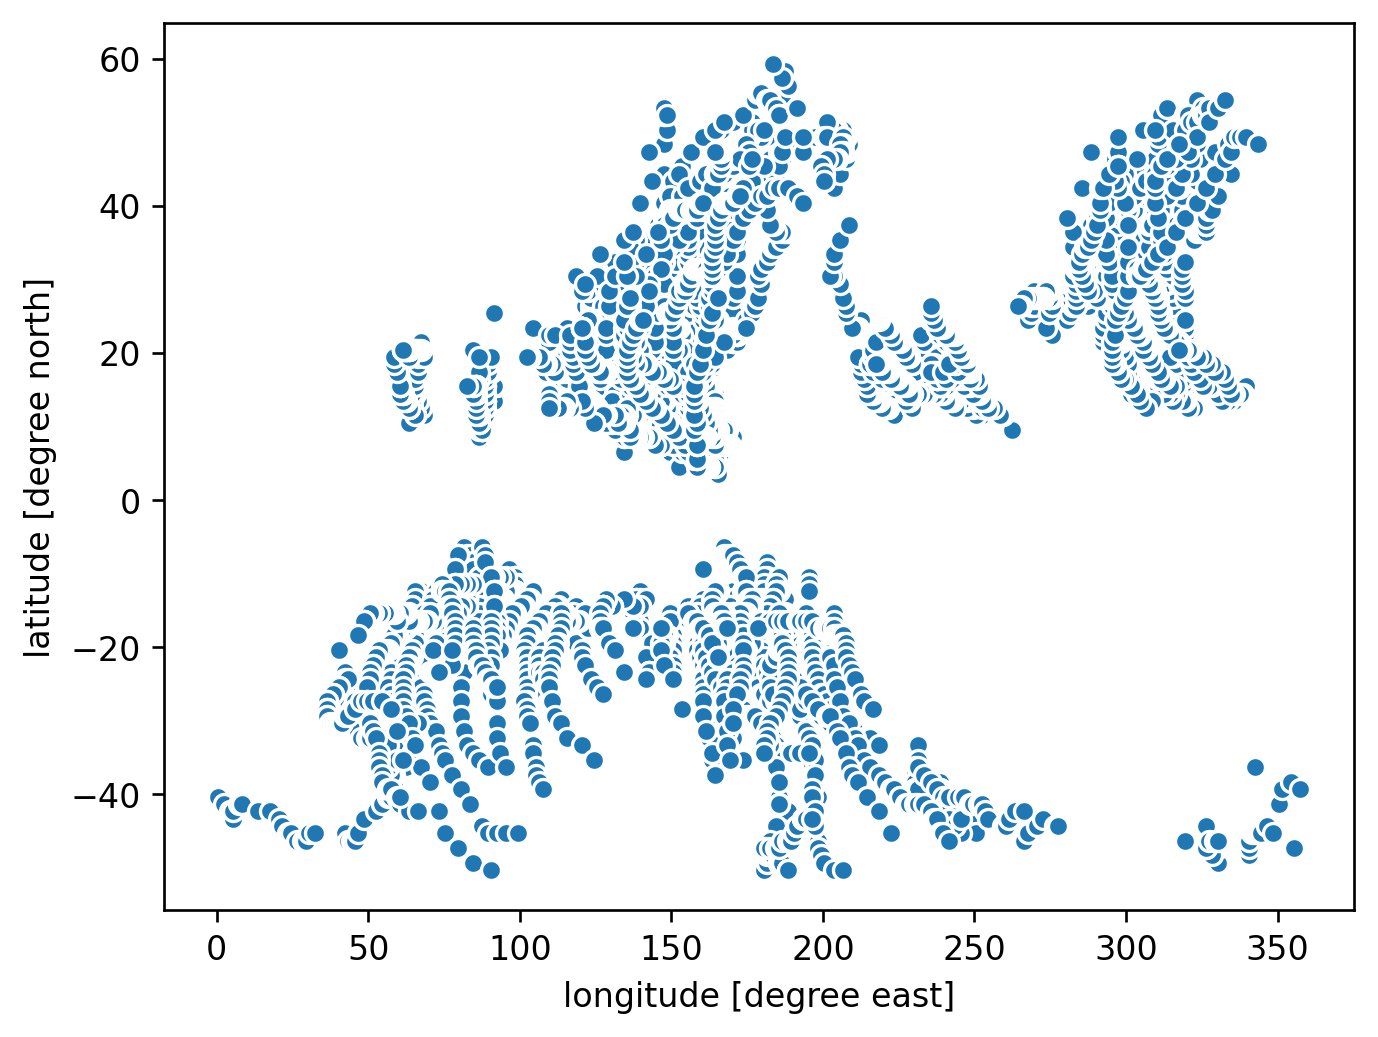

In [99]:
ace2.plot.scatter(x='lon', y='lat')

In [52]:
era5_2004 = era5.sel(year_final=2004)

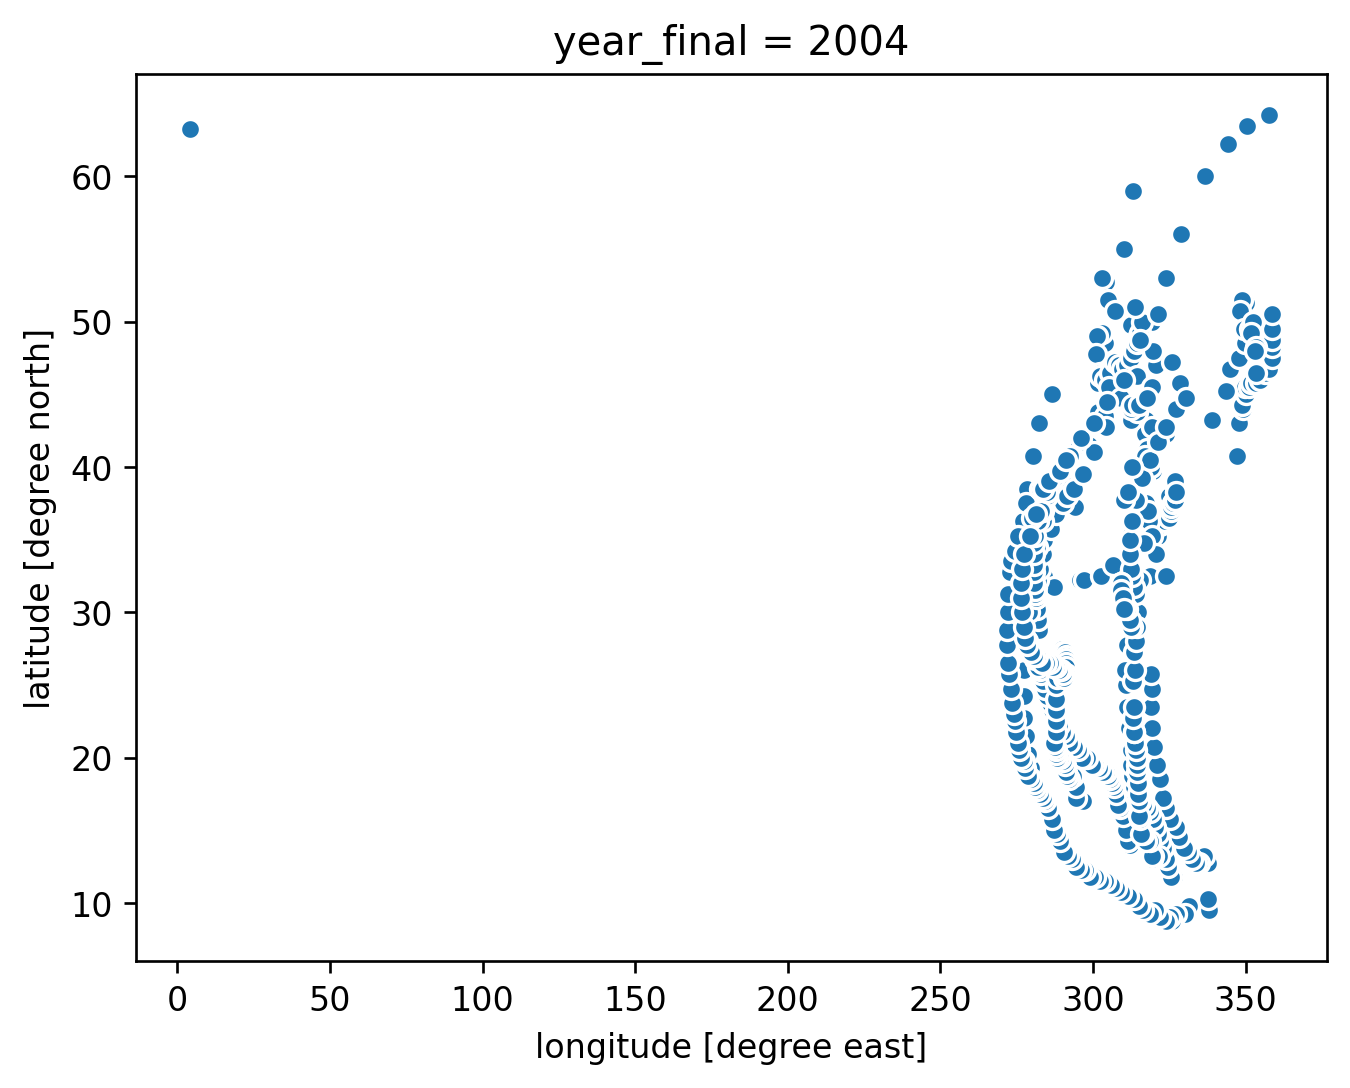

In [57]:
era5_2004.where(L).plot.scatter(x='lon', y='lat')

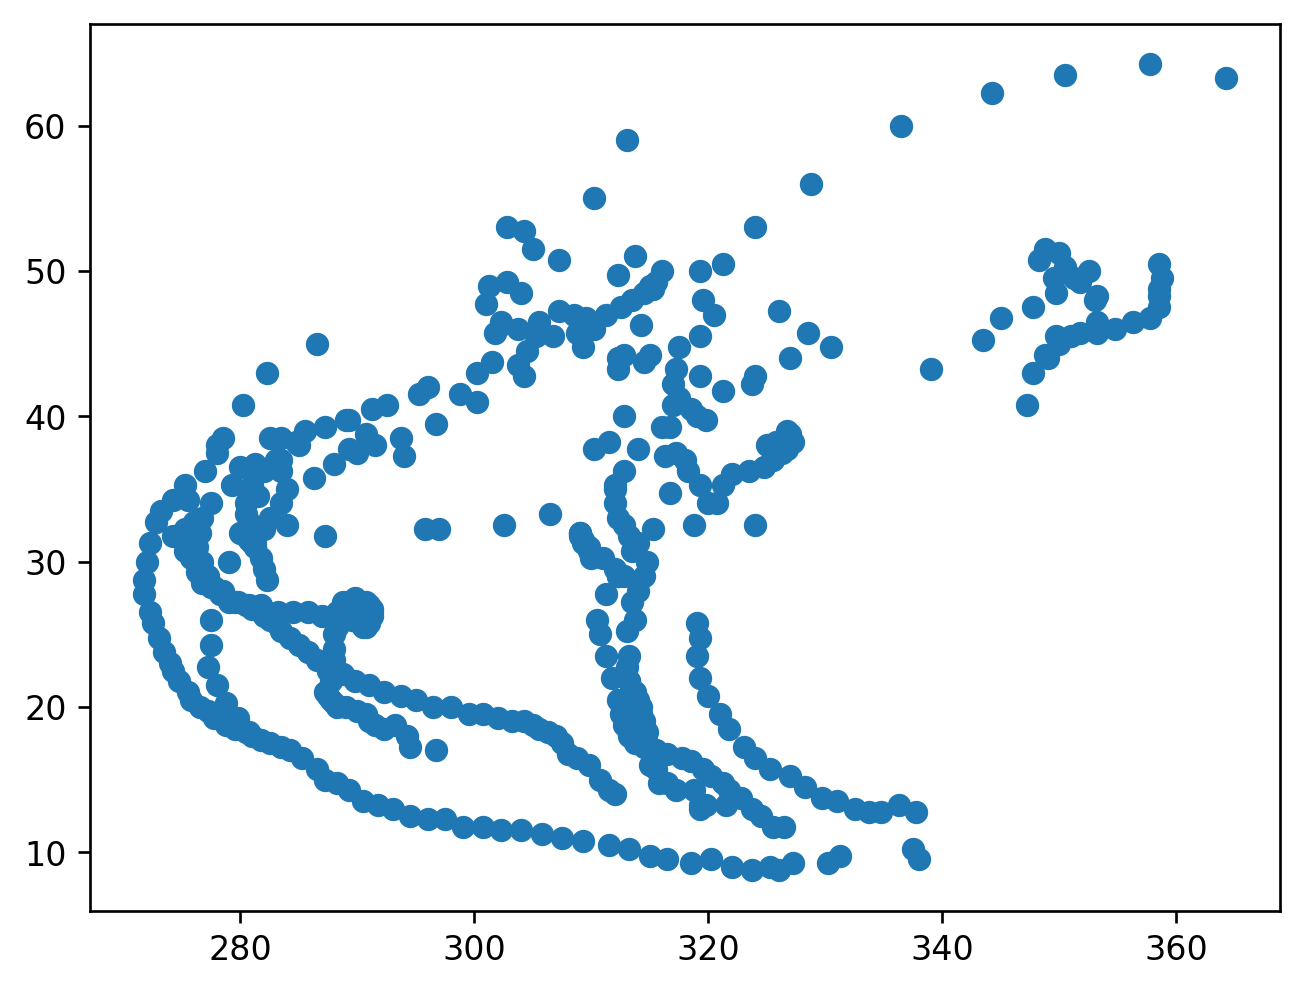

In [62]:
lon = era5_2004.where(L).lon
lat = era5_2004.where(L).lat
windmax = era5_2004.where(L).windmax
lon = lon.where(lon>180, other=lon+360)
plt.scatter(lon, lat)

In [63]:
ds_2004 = xr.Dataset(dict(lon=lon, lat=lat, windmax=windmax))

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


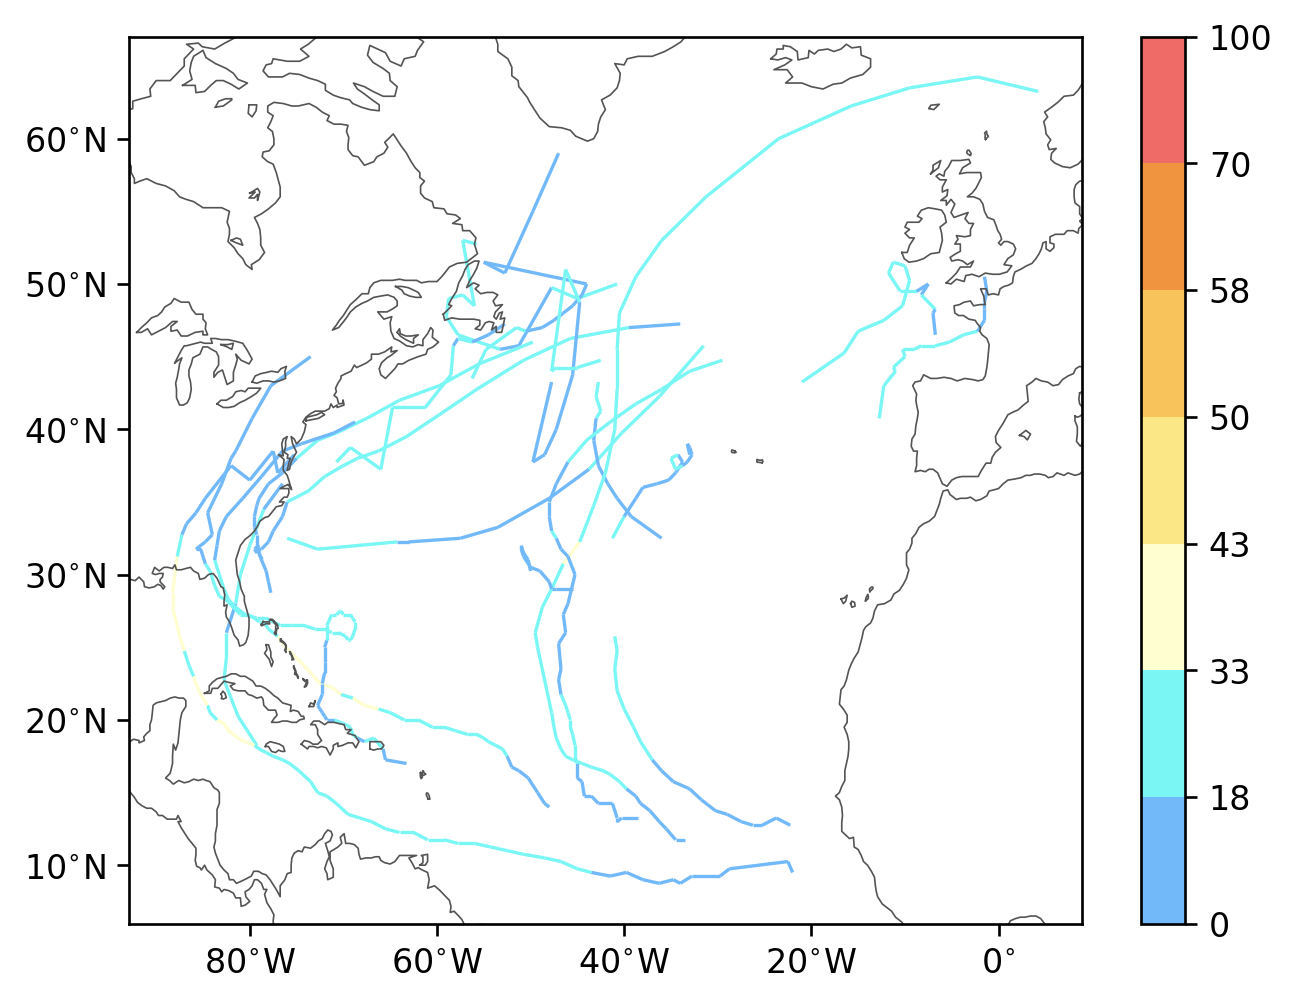

In [66]:
basin = 'NA'
L = ds_2004.isel(stage=0).pipe(tracks_in_basin, basin)
lines = ds_2004.where(L).pipe(trackplot)
mapplot()
plt.colorbar(lines.values[0])

In [65]:
lines

<xarray.DataArray (storm: 116)> Size: 928B
array([<matplotlib.collections.LineCollection object at 0x147fe1376860>,
       <matplotlib.collections.LineCollection object at 0x147fe1316fb0>,
       <matplotlib.collections.LineCollection object at 0x147fe13175b0>,
       <matplotlib.collections.LineCollection object at 0x147fe1317910>,
       <matplotlib.collections.LineCollection object at 0x147fe1317c70>,
       <matplotlib.collections.LineCollection object at 0x147fe1140250>,
       <matplotlib.collections.LineCollection object at 0x147fe1140580>,
       <matplotlib.collections.LineCollection object at 0x147fe11408e0>,
       <matplotlib.collections.LineCollection object at 0x147fe1140c40>,
       <matplotlib.collections.LineCollection object at 0x147fe1140fa0>,
       <matplotlib.collections.LineCollection object at 0x147fe1141300>,
       <matplotlib.collections.LineCollection object at 0x147fe1141660>,
       <matplotlib.collections.LineCollection object at 0x147fe11419c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1141d20>,
       <matplotlib.collections.LineCollection object at 0x147fe1142290>,
       <matplotlib.collections.LineCollection object at 0x147fe11425c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1142920>,
       <matplotlib.collections.LineCollection object at 0x147fe1142e90>,
       <matplotlib.collections.LineCollection object at 0x147fe11431c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1143520>,
...
       <matplotlib.collections.LineCollection object at 0x147fe109cd00>,
       <matplotlib.collections.LineCollection object at 0x147fe109d060>,
       <matplotlib.collections.LineCollection object at 0x147fe109d3c0>,
       <matplotlib.collections.LineCollection object at 0x147fe109d720>,
       <matplotlib.collections.LineCollection object at 0x147fe109da80>,
       <matplotlib.collections.LineCollection object at 0x147fe109dde0>,
       <matplotlib.collections.LineCollection object at 0x147fe109e140>,
       <matplotlib.collections.LineCollection object at 0x147fe109e4a0>,
       <matplotlib.collections.LineCollection object at 0x147fe109e800>,
       <matplotlib.collections.LineCollection object at 0x147fe109eb60>,
       <matplotlib.collections.LineCollection object at 0x147fe109eec0>,
       <matplotlib.collections.LineCollection object at 0x147fe109f220>,
       <matplotlib.collections.LineCollection object at 0x147fe109f580>,
       <matplotlib.collections.LineCollection object at 0x147fe109f8e0>,
       <matplotlib.collections.LineCollection object at 0x147fe109fc40>,
       <matplotlib.collections.LineCollection object at 0x147fe109ffa0>,
       <matplotlib.collections.LineCollection object at 0x147fe10d4340>,
       <matplotlib.collections.LineCollection object at 0x147fe10d46a0>,
       <matplotlib.collections.LineCollection object at 0x147fe10d4a00>],
      dtype=object)
Coordinates:
  * storm       (storm) int64 928B 1 2 3 4 5 6 7 ... 110 111 112 113 114 115 116
    year_final  int64 8B 2004

In [42]:
era5_2005.plot(x='lon', y='lat')

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

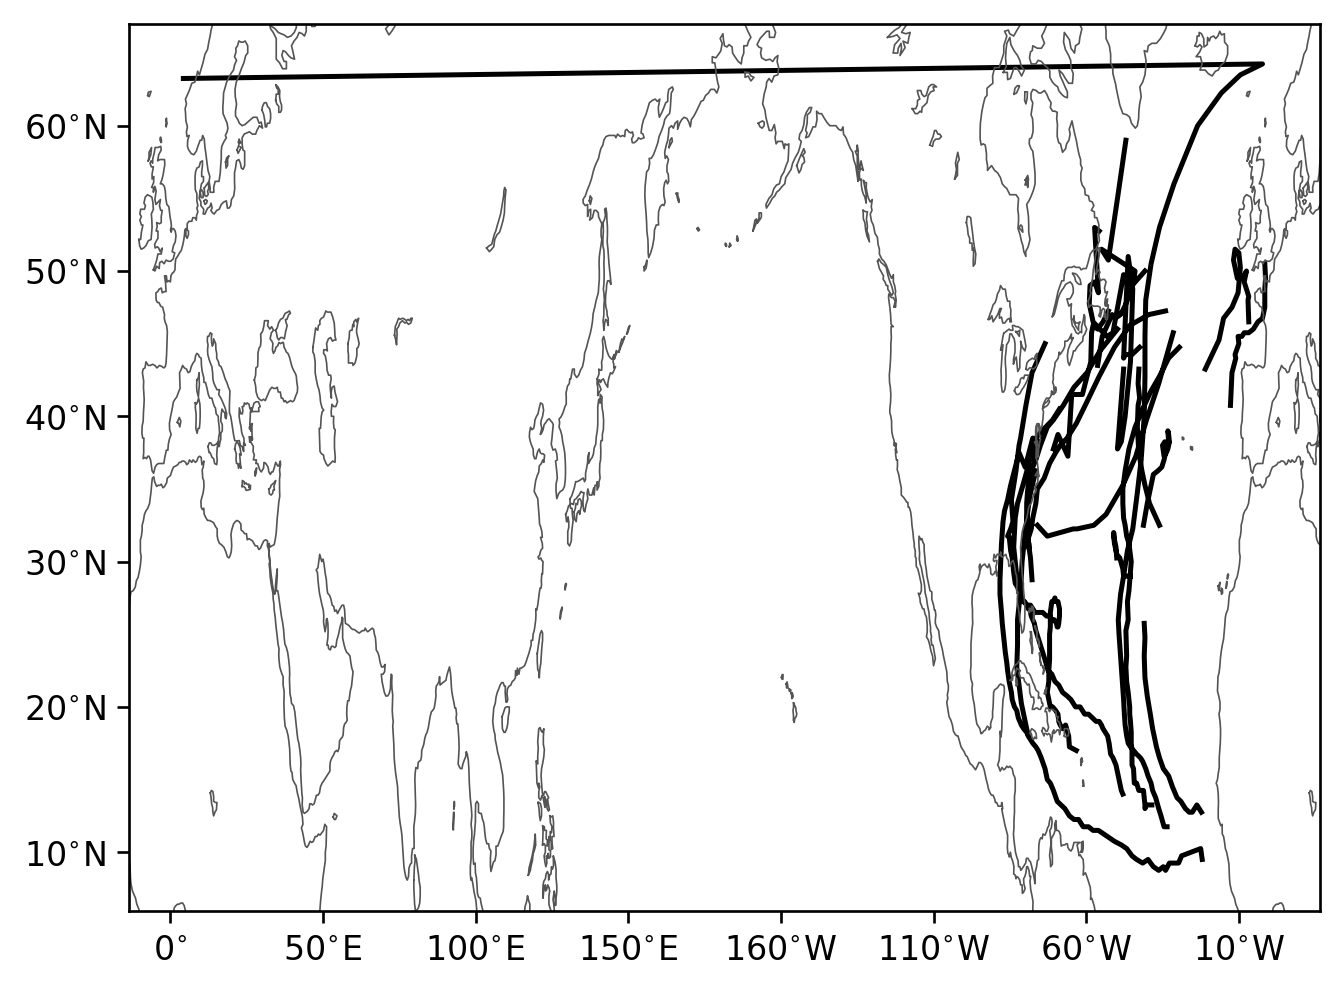

In [54]:
plt.plot(era5_2004.where(L).lon.values.flat, era5_2004.where(L).lat.values.flat, color='k')
mapplot()
plt.show()

In [30]:
lines.isel(year_final=0, storm=0).item()

In [32]:
lines.values[0,0]

In [18]:
plt.colorbar?

Signature:
plt.colorbar(
    mappable: 'ScalarMappable | None' = None,
    cax: 'matplotlib.axes.Axes | None' = None,
    ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None,
    **kwargs,
) -> 'Colorbar'
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
    `.ContourSet`, etc.) described by this colorbar.  This argument is
    mandatory for the `.Figure.colorbar` method but optional for the
    `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to
    generate colorbars not attached to a previously drawn artist, e.g.
    ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.  If `None`, then a new
    Axes is created and the space for it will be stolen from the Axes(s)
    specified in *ax*.


In [36]:
era5.pipe(trackplot, ezplot=True, lw=0.5, alpha=0.5)
mapplot()

TypeError: single_track_plot() got an unexpected keyword argument 'ezplot'

In [67]:
ace2

<xarray.Dataset> Size: 2MB
Dimensions:      (storm: 207, stage: 120)
Coordinates:
  * storm        (storm) int64 2kB 1 2 3 4 5 6 7 ... 201 202 203 204 205 206 207
  * stage        (stage) int64 960B 0 6 12 18 24 30 ... 684 690 696 702 708 714
Data variables:
    lat          (storm, stage) float64 199kB -10.47 -10.47 -9.474 ... nan nan
    lon          (storm, stage) float64 199kB 92.5 92.5 95.5 ... nan nan nan
    windmax      (storm, stage) float64 199kB 16.63 15.49 19.48 ... nan nan nan
    slp          (storm, stage) float64 199kB 1.005e+05 1.006e+05 ... nan nan
    hsfc         (storm, stage) float64 199kB -4.965 -4.965 -5.704 ... nan nan
    windmax_10m  (storm, stage) float64 199kB 12.56 11.95 13.56 ... nan nan nan
    year         (storm, stage) float64 199kB 2.002e+03 2.002e+03 ... nan nan
    month        (storm, stage) float64 199kB 1.0 1.0 1.0 1.0 ... nan nan nan
    day          (storm, stage) float64 199kB 1.0 1.0 2.0 3.0 ... nan nan nan
    hour         (storm, stage) float64 199kB 6.0 18.0 18.0 0.0 ... nan nan nan

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


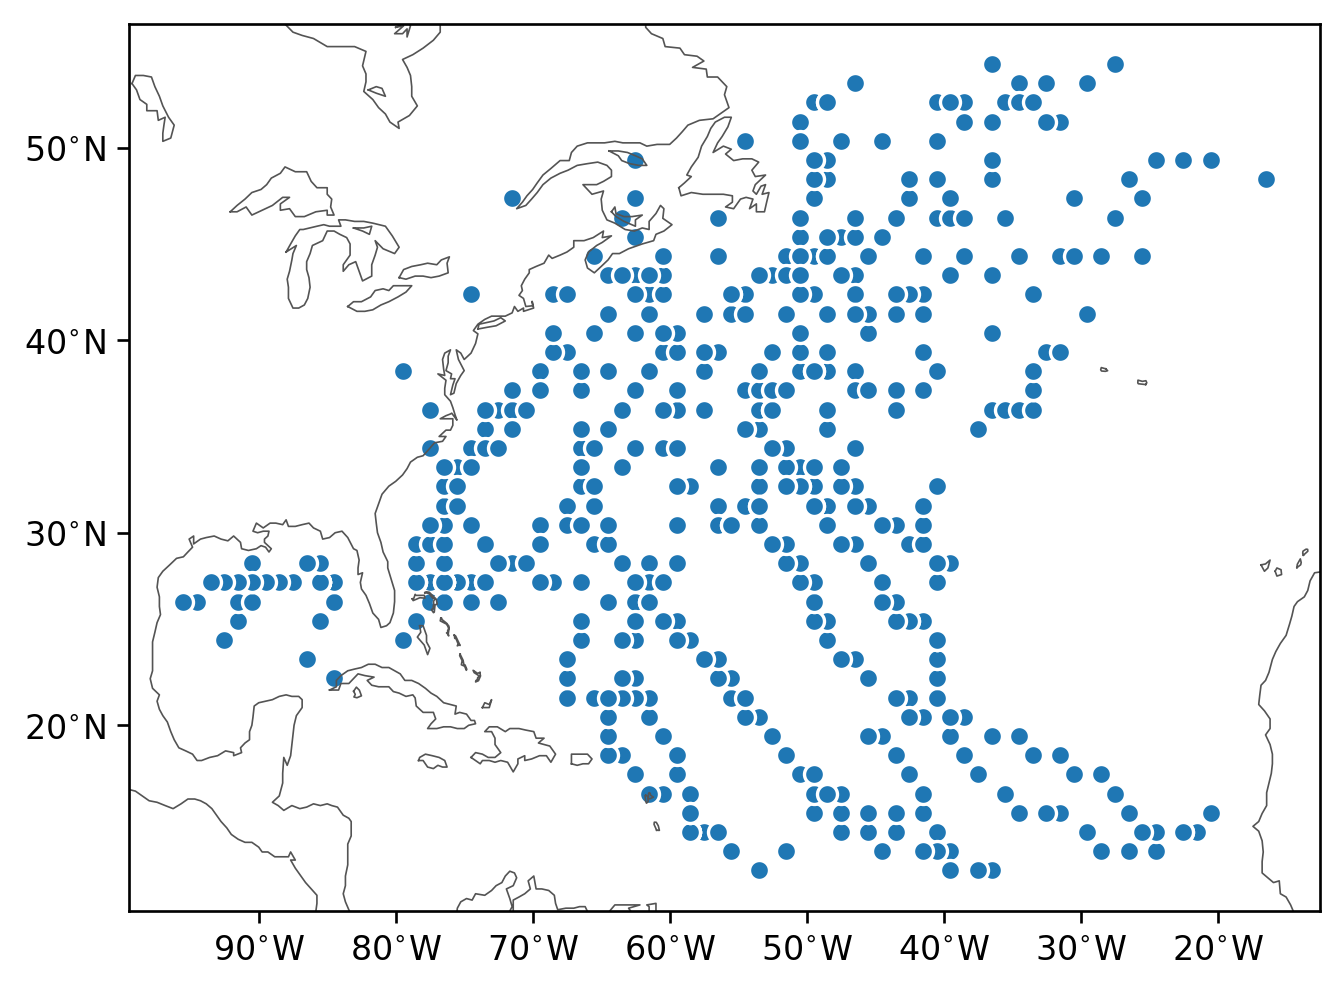

In [72]:
ace2.where(tracks_in_basin(ace2.isel(stage=0), 'NA')).plot.scatter(x='lon', y='lat')
mapplot()

In [80]:
ace2_2005 = ace2.where(ace2.year==2005)

In [75]:
ace2.where(year=2005)

TypeError: DataWithCoords.where() got an unexpected keyword argument 'year'

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


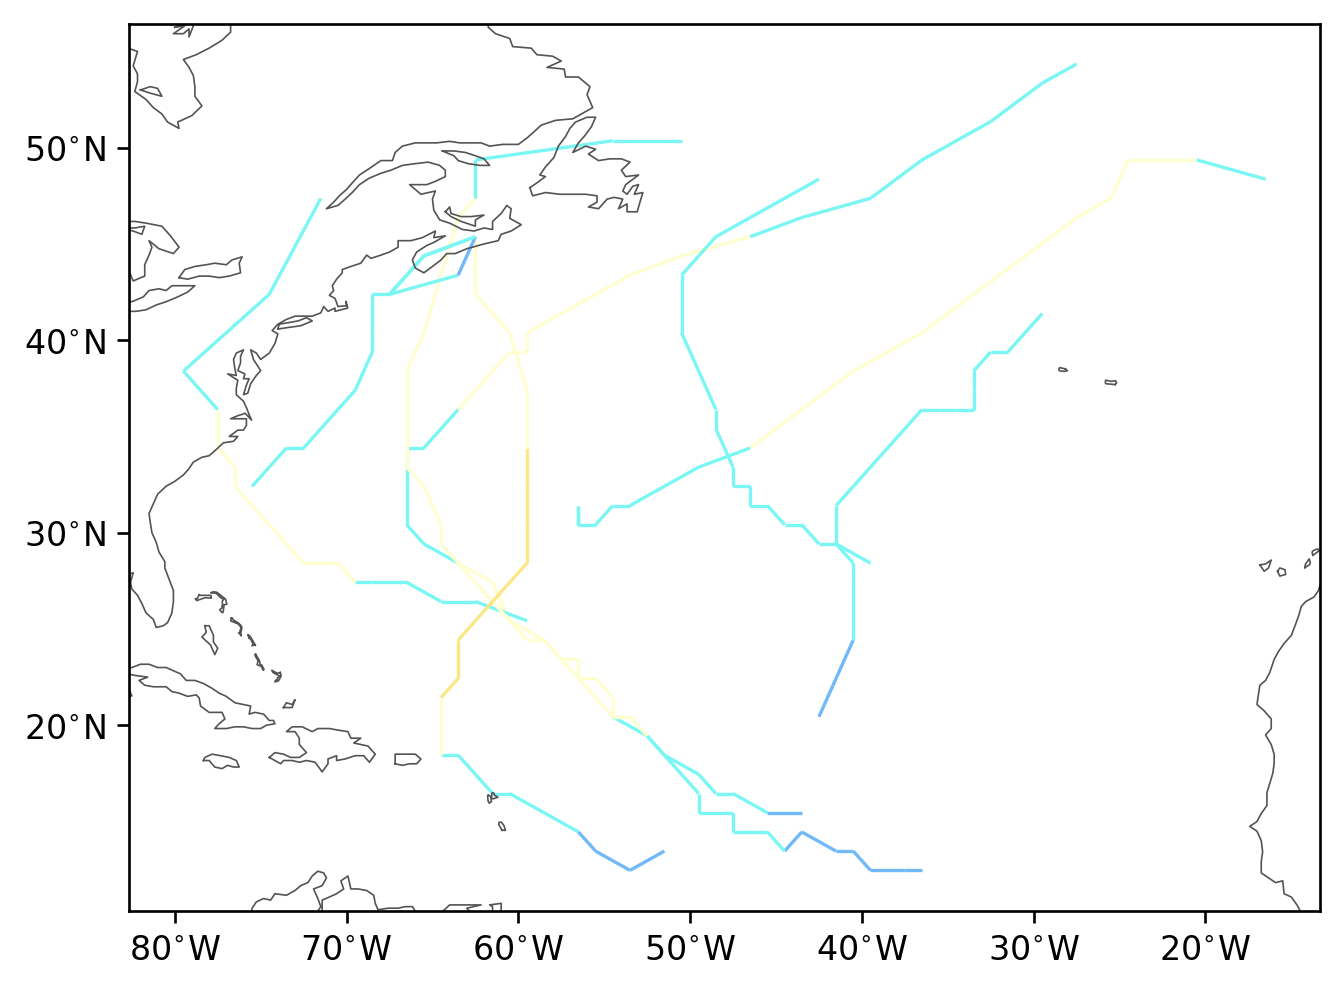

In [82]:
basin = 'NA'
L = tracks_in_basin(ace2_2005.isel(stage=0), 'NA')
ace2_2005.where(L).pipe(trackplot)
mapplot()

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])
/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


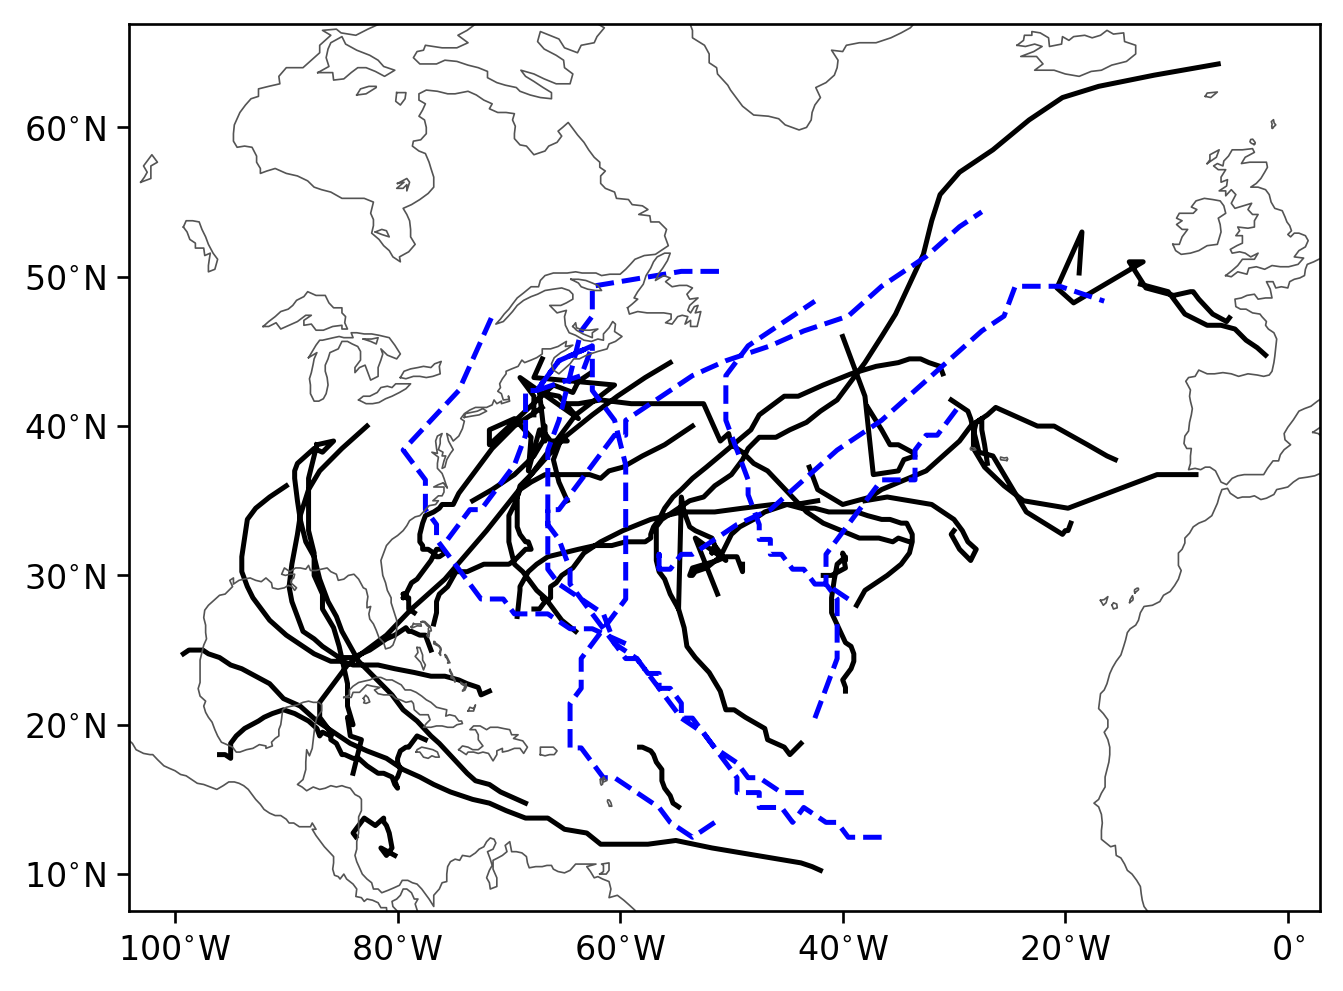

In [84]:
plt.plot(era5_2005.where(tracks_in_basin(era5_2005, 'NA')).lon.values.flat, era5_2005.where(tracks_in_basin(era5_2005, 'NA')).lat.values.flat, color='k')

plt.plot(ace2_2005.where(L).lon.values.flat, ace2_2005.where(L).lat.values.flat, color='b', linestyle='--')
mapplot()
plt.show()

In [18]:
era5.pipe(trackplot, ezplot=True, lw=0.5, alpha=0.5)
mapplot()

TypeError: single_track_plot() got an unexpected keyword argument 'ezplot'

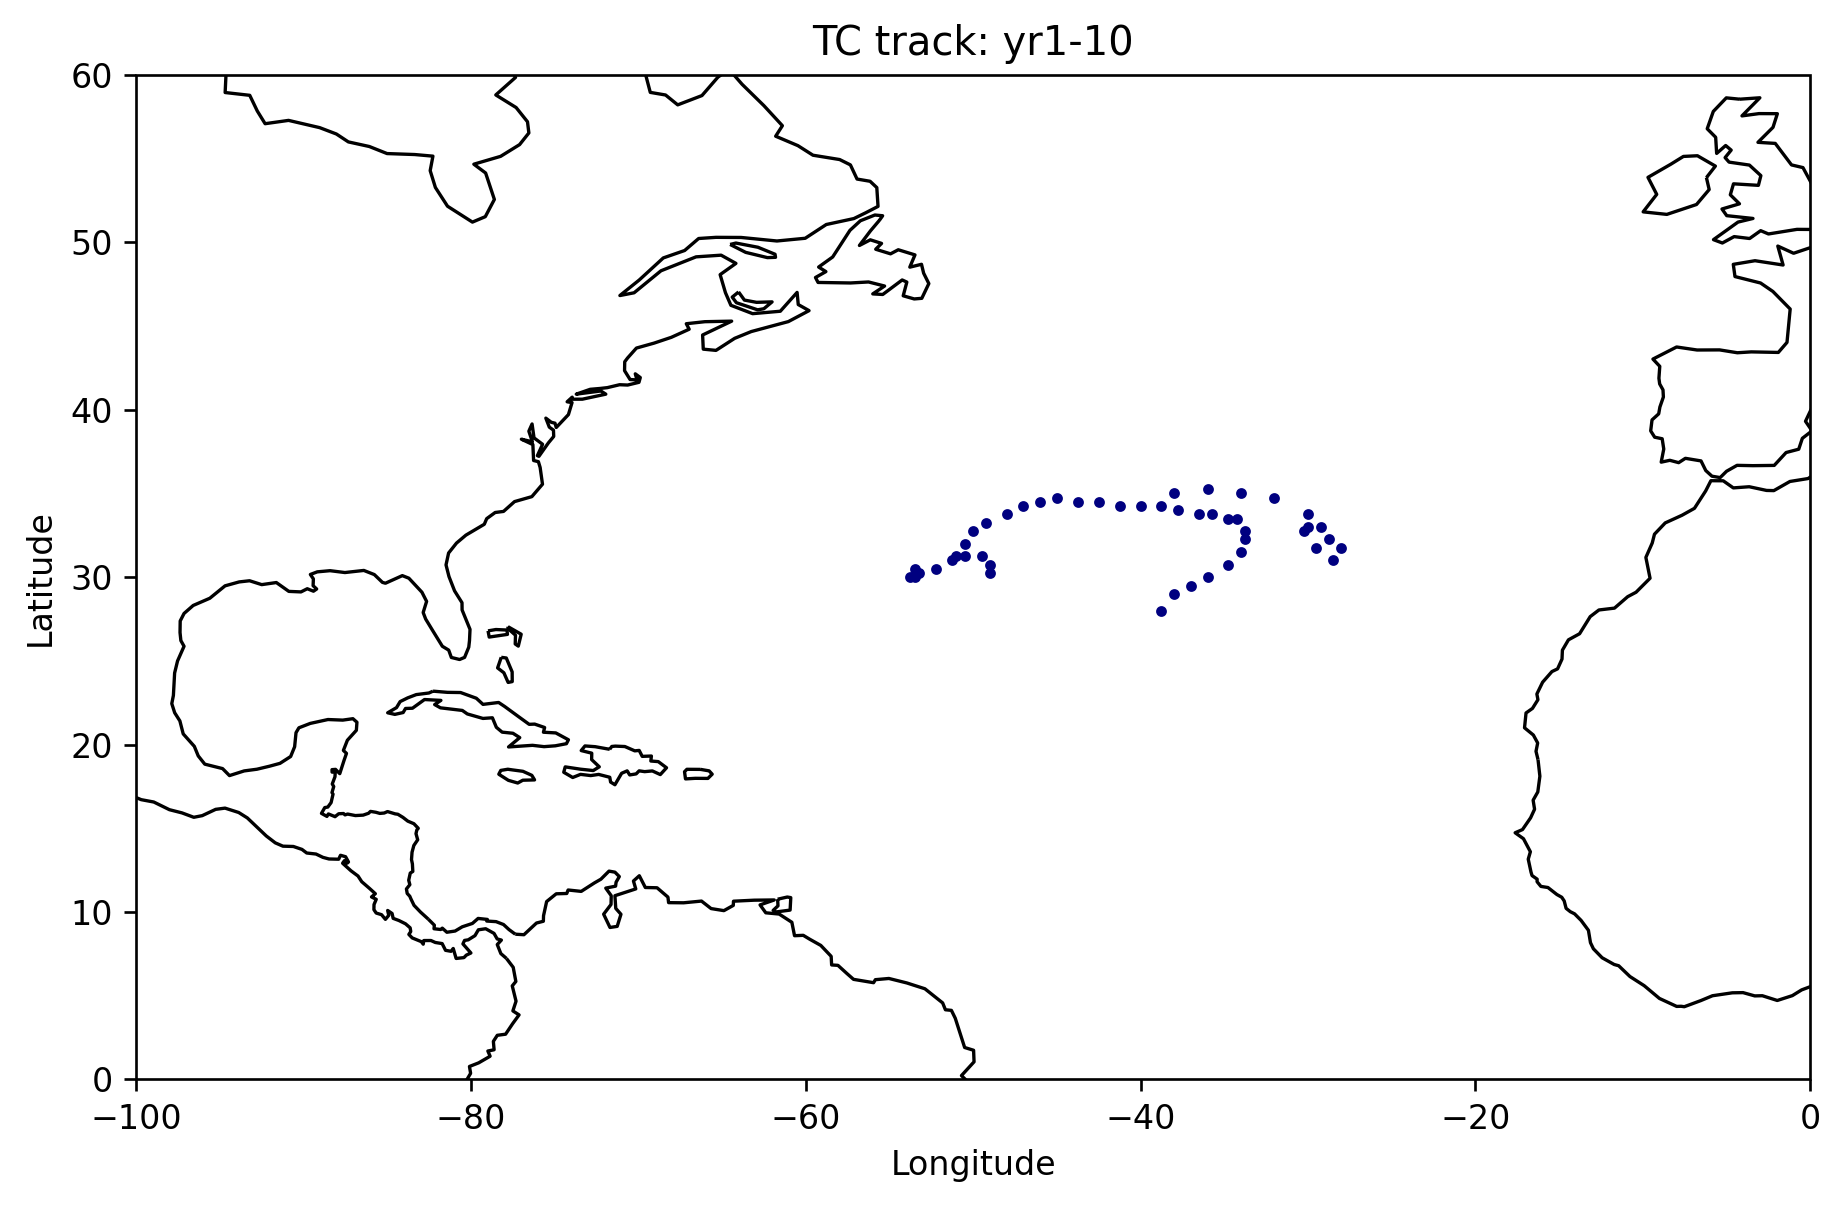

In [85]:
# Set up subplots with PlateCarree projection
year_mask = ace2.year.isin([2004, 2005])


# Apply mask to all variables — where the condition is False, values become NaN
ace2_2004_2005 = ds.where(year_mask, drop=False)  # drop=False keeps full shape with NaNs

fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 8.5))

plt.scatter(ace2_2004_2005.lon, ace2_2004_2005.lat, color='navy', s=5, transform=ccrs.PlateCarree())

axes.coastlines()
axes.set_xticks(np.arange(-100, 20, 20), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(0, 61, 10), crs=ccrs.PlateCarree())
axes.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())

plt.title('TC track: yr1-10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


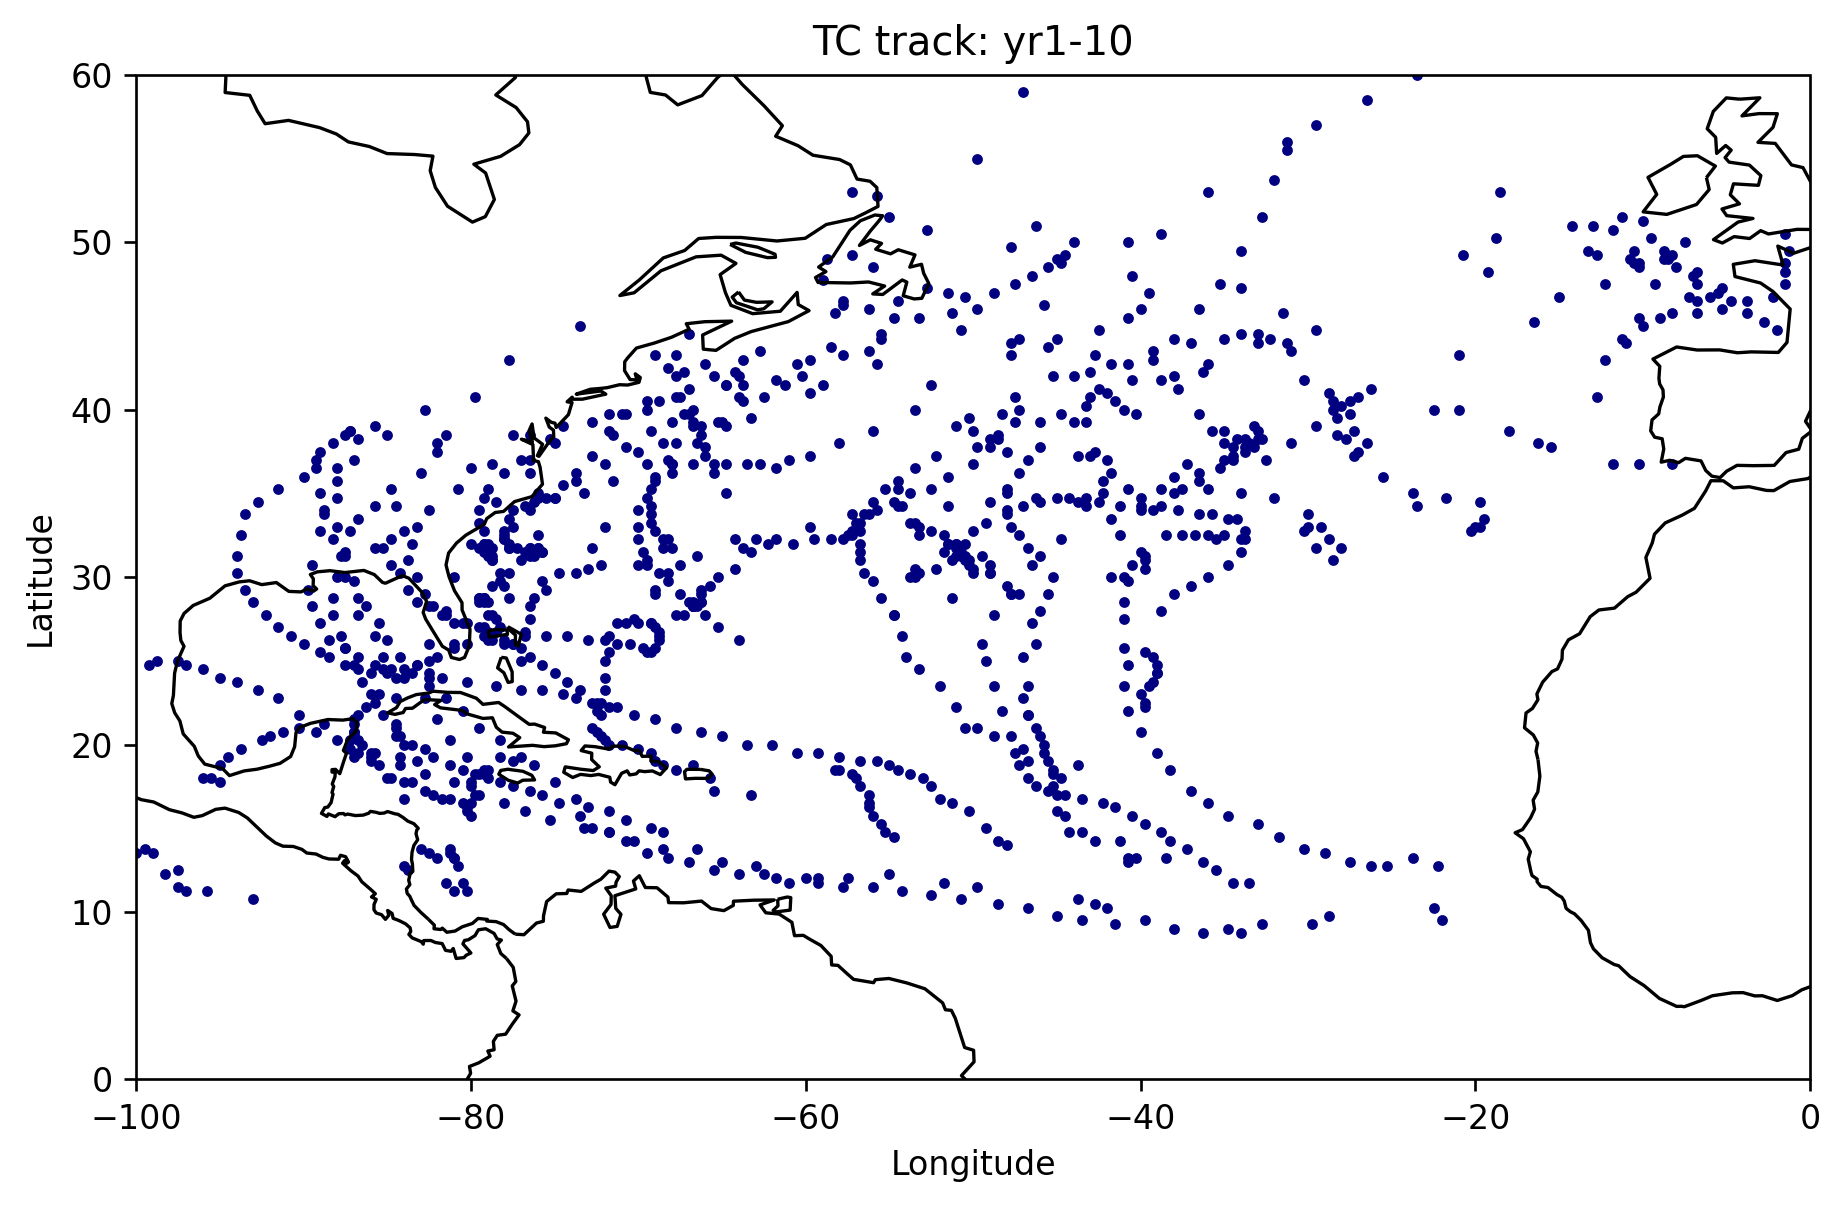

In [43]:


fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 8.5))

plt.scatter(era5.lon, era5.lat, color='navy', s=5, transform=ccrs.PlateCarree())

axes.coastlines()
axes.set_xticks(np.arange(-100, 20, 20), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(0, 61, 10), crs=ccrs.PlateCarree())
axes.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())

plt.title('TC track: yr1-10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
